# Graph Analysis

This notebook analyzes the recommendation graph

In [54]:
import os
import pandas
import json
import numpy as np
import pandas as pd

import networkx as nx
from matplotlib import pyplot as plt

In [55]:
# import the graph from adjacency list
G = nx.read_adjlist(create_using=nx.DiGraph(), 
                    path="derived_data/adjacency_list.txt")
#nx.write_graphml(G, 'derived_data/rec_graph.graphml')

# wrap in the features I collected 
with open('results/video_info.json', 'r') as f:
    video_info = json.load(f)

In [74]:
# make a category_name <-> id mapping for easier category handling
category_list = [category[id] for id in category]
categories = set(category_list)
cat_mapping = {}
for ix, category_id in enumerate(categories):
    cat_mapping[category_id] = ix
    
category = {}
views = {}
lr = {}
postdate = {}
channel = {}
for video_id in video_info:
    info = video_info.get(video_id, {})
    try:
        like_ratio = int(info['likes']) / (int(info['likes']) + int(info['dislikes']))
    except ZeroDivisionError:
        like_ratio = 0.5
    
    channel[video_id] = info['channel']
    category[video_id] = cat_mapping[info['category']]
    views[video_id] = int(info['views'])
    lr[video_id] = float(like_ratio)
    postdate[video_id] =  info['postdate']
    
    
nx.set_node_attributes(G, name='category', values=category)
nx.set_node_attributes(G, name='views', values=views)
nx.set_node_attributes(G, name='like_ratio', values=lr)
nx.set_node_attributes(G, name='postdate', values=postdate)
nx.set_node_attributes(G, name='channel', values=channel)

In [75]:
# assortativity
print(nx.attribute_assortativity_coefficient(G, 'category'))
print(nx.attribute_assortativity_coefficient(G, 'channel'))
#print(nx.numeric_assortativity_coefficient(G, attribute='views'))
#print(nx.numeric_assortativity_coefficient(G, attribute='like_ratio'))

0.5384591277043769
0.4277838215563446


In [93]:
# mix_matrix[i,j] = count of i -> j edges
mix_matrix = nx.attribute_mixing_matrix(G, 
                                   attribute='category',
                                   normalized=False)

# normalize so rows sum to 1; choosing rows so that each cell can
# be interpreted as the frequency with which category i recommends a video
# in category j (row sums are the out-degree)
mix_matrix = mix_matrix / mix_matrix.sum(axis=1, keepdims=True)

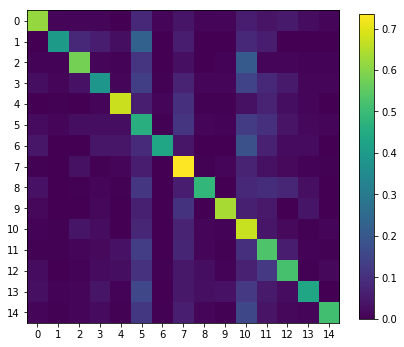

In [95]:
plt.figure(figsize=(7,7))
plt.imshow(mix_matrix)
plt.colorbar(shrink=0.8)
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))
plt.savefig('presentation_resources/mixing_matrix', dpi=300)

In [105]:
# pageranks
pr = nx.pagerank(G)

pr_df = pd.DataFrame.from_dict(pr, orient="index").reset_index()\
                 .rename(index=str, columns={'index': 'video_id', 0: 'pagerank'})
    
pr_df.to_csv('derived_data/pageranks.csv', index=False)